<a href="https://colab.research.google.com/github/kapko/Titanik_kaggle/blob/main/Titanik.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

test = pd.read_csv('/content/sample_data/test.csv')
train = pd.read_csv('/content/sample_data/train.csv')


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


<Axes: >

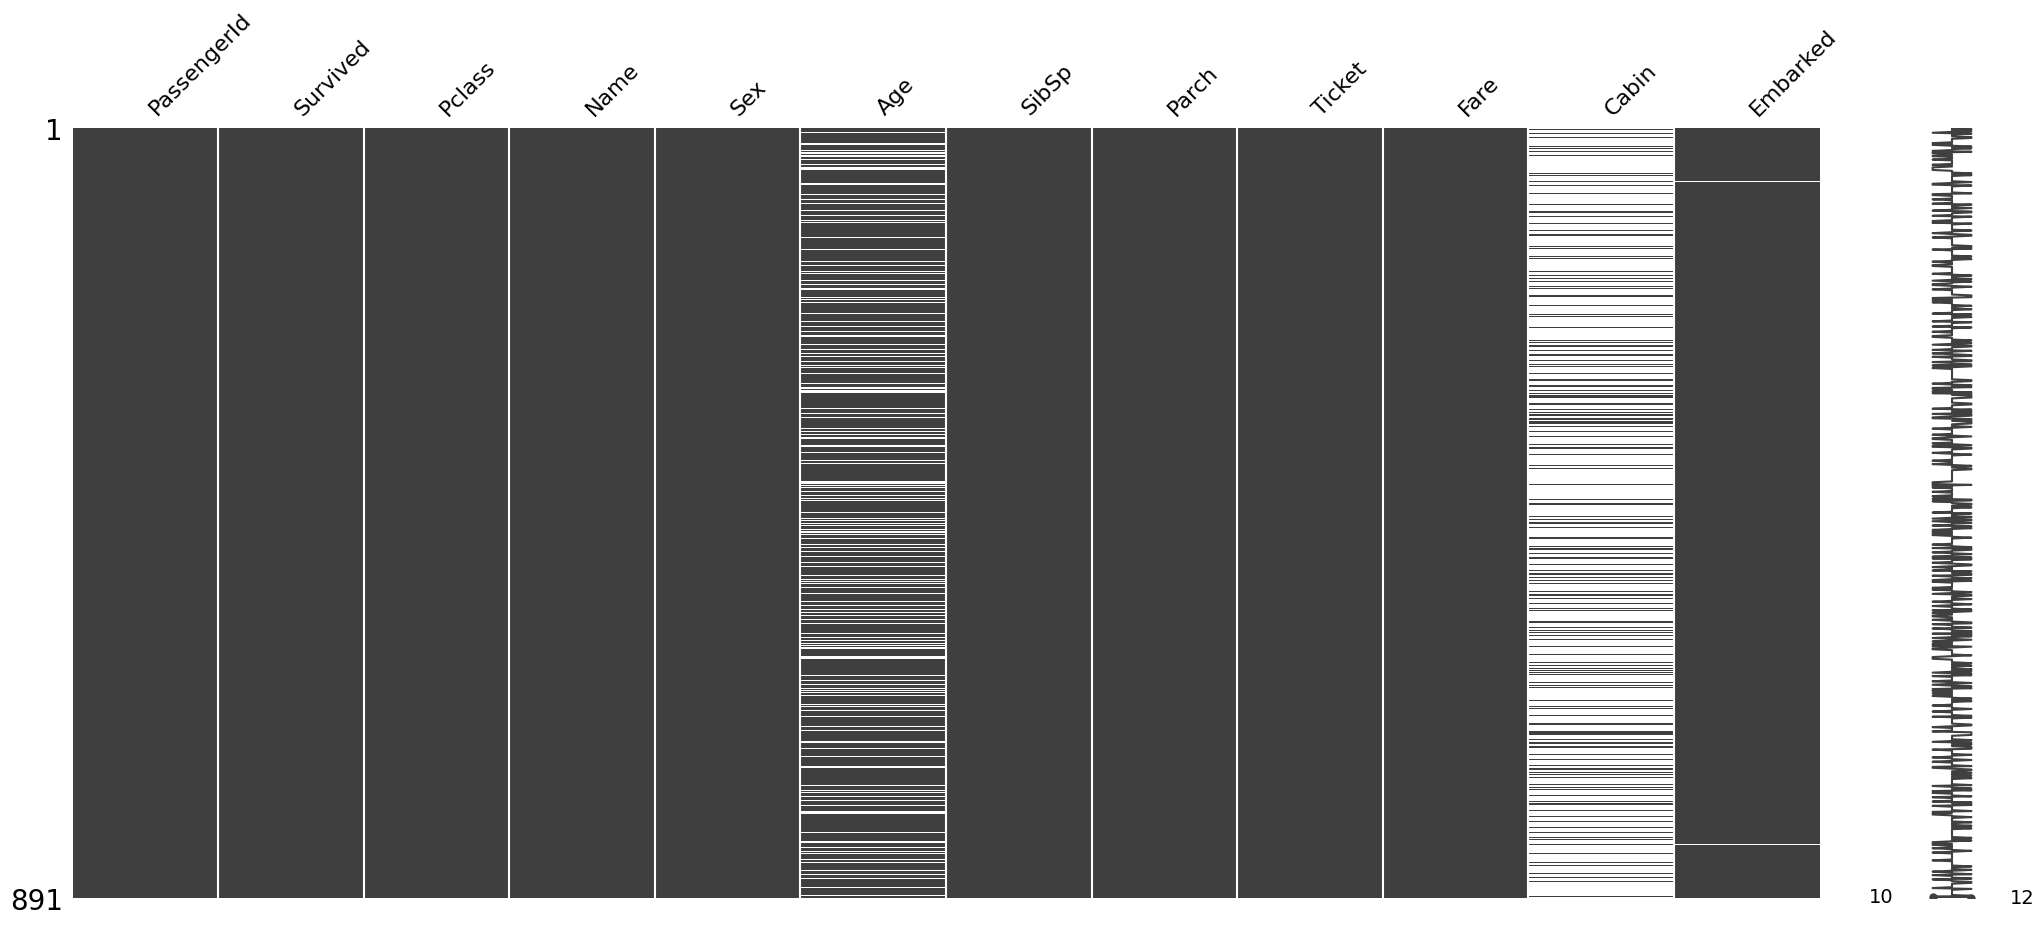

In [4]:
import missingno as msno
msno.matrix(train)

<Axes: xlabel='Pclass', ylabel='Survived'>

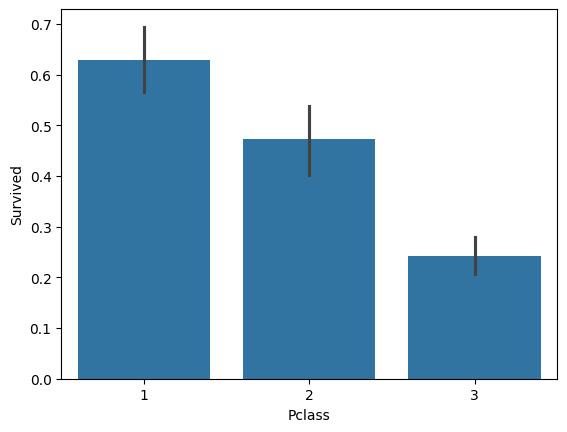

In [5]:
sns.barplot(train, x='Pclass', y='Survived')

<Axes: xlabel='Sex', ylabel='Survived'>

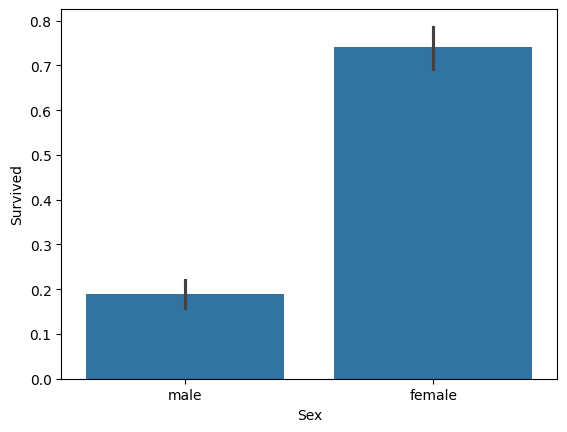

In [6]:
sns.barplot(train, x='Sex', y='Survived')

<Axes: >

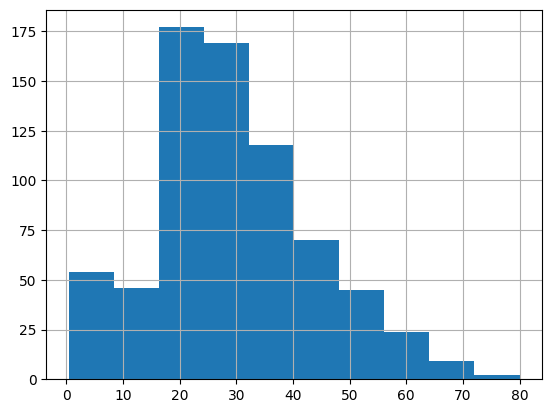

In [7]:
train.Age.hist()

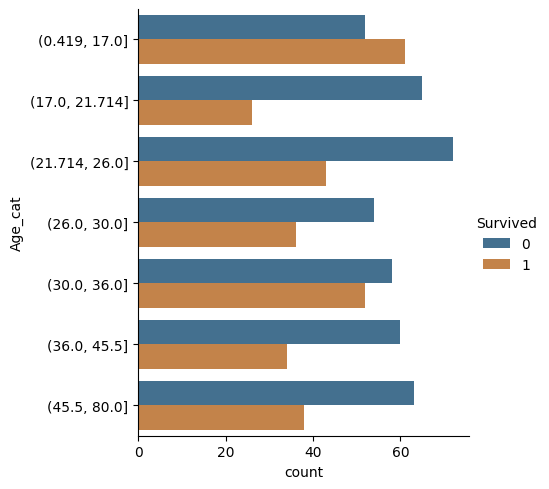

In [8]:
train['Age_cat'] = pd.qcut(train.Age,7)
sns.catplot(data=train, y='Age_cat', hue='Survived', kind='count', saturation=0.5)

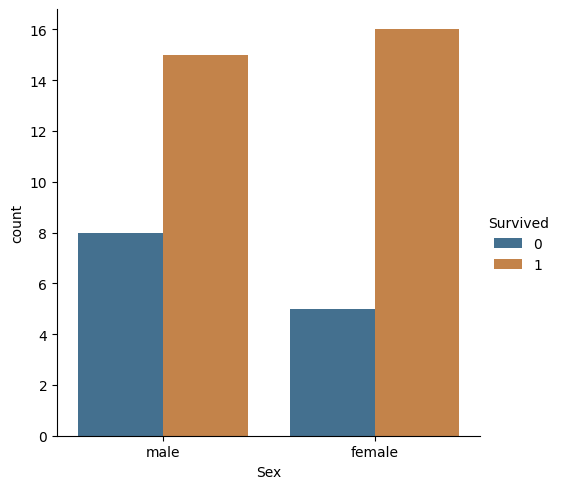

In [9]:
child= train[train.Age<6]
sns.catplot(data = child, hue='Survived',  x='Sex',kind='count', saturation=0.5)

/tmp/ipython-input-1666072345.py:6: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pt = tmp.pivot_table(index='Pclass', columns='AgeBin', values='Survived', aggfunc='mean')


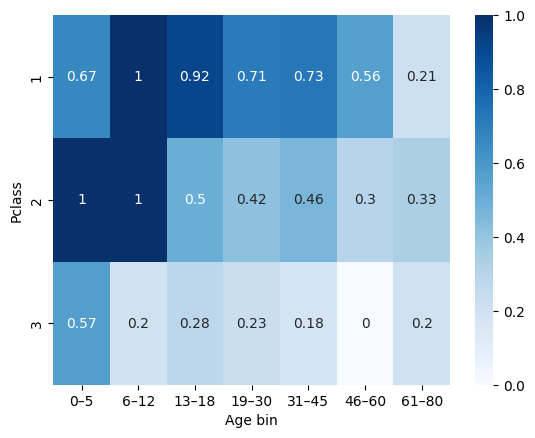

In [10]:
tmp = train[['Age','Pclass','Survived']].dropna().copy()
bins = [0,5,12,18,30,45,60,80]
labels = ['0–5','6–12','13–18','19–30','31–45','46–60','61–80']
tmp['AgeBin'] = pd.cut(tmp['Age'], bins=bins, labels=labels, include_lowest=True)

pt = tmp.pivot_table(index='Pclass', columns='AgeBin', values='Survived', aggfunc='mean')
sns.heatmap(pt, annot=True, vmin=0, vmax=1, cmap='Blues')
plt.ylabel('Pclass'); plt.xlabel('Age bin'); plt.show()

In [11]:
train['Cabin_was_missing'] = train['Cabin'].isna().astype('int8')
train['Deck'] = train['Cabin'].astype('string').str[0].fillna('U')

most_common_embarked = train.Embarked.mode(dropna=True).iat[0]
mean_age = train.Age.mean()

most_common_embarked_test = test.Embarked.mode(dropna=True).iat[0]
mean_age_test = test.Age.mean()

train.Embarked = train.Embarked.fillna(most_common_embarked)
train.Age = train.Age.fillna(mean_age)

test.Embarked = test.Embarked.fillna(most_common_embarked_test)
test.Age = test.Age.fillna(mean_age_test)


In [12]:
def simplify_title(name):
    title = name.split(',')[1].split('.')[0].strip()
    if title in ['Mr']:
        return 'Mr'
    elif title in ['Mrs']:
        return 'Mrs'
    elif title in ['Miss', 'Mlle', 'Ms']:
        return 'Miss'
    elif title in ['Master']:
        return 'Master'
    else:
        return 'Rare'

train['Title'] = train['Name'].apply(simplify_title)
test['Title'] = test['Name'].apply(simplify_title)

In [13]:
train['Cabin_was_missing'] = train['Cabin'].isna().astype('int8')
train['Deck'] = train['Cabin'].astype('string').str[0].fillna('U')

train['Cabin_was_missing'] = train['Cabin'].isna().astype('int8')
test['Deck'] = test['Cabin'].astype('string').str[0].fillna('U')

In [14]:
train['IsChild'] = (train['Age'] < 14).astype('int8')
train['IsSenior'] = (train['Age'] >= 14).astype('int8')
test['IsChild'] = (test['Age'] < 14).astype('int8')
test['IsSenior'] = (test['Age'] >= 14).astype('int8')

In [15]:
train['FamilySize'] = (train['SibSp'] + train['Parch']) + 1
test['FamilySize'] = (test['SibSp'] + test['Parch']) + 1

train['FamilySizeBin'] = pd.cut(
    train['FamilySize'],
    bins=[0,1,4,20],
    labels=['Alone','Small','Large']
)

test['FamilySizeBin'] = pd.cut(
    test['FamilySize'],
    bins=[0,1,4,20],
    labels=['Alone','Small','Large']
)

In [16]:
# базовые бинарные/числовые
train['IsFemale'] = (train['Sex'] != 'male').astype('int8')
train['FamilySize'] = (train['SibSp'] + train['Parch'] + 1).astype('int16')
train['IsAlone'] = (train['FamilySize'] == 1).astype('int8')
train['FarePerPerson'] = (train['Fare'] / train['FamilySize'])

# флаги пропусков
train['Age_was_missing'] = train['Age'].isna().astype('int8')
train['Fare_was_missing'] = train['Fare'].isna().astype('int8')
train['Embarked_was_missing'] = train['Embarked'].isna().astype('int8')

# === TEST ===
test['IsFemale'] = (test['Sex'] != 'male').astype('int8')
test['FamilySize'] = (test['SibSp'] + test['Parch'] + 1).astype('int16')
test['IsAlone'] = (test['FamilySize'] == 1).astype('int8')
test['FarePerPerson'] = test['Fare'] / test['FamilySize']

test['Age_was_missing'] = test['Age'].isna().astype('int8')
test['Fare_was_missing'] = test['Fare'].isna().astype('int8')
test['Embarked_was_missing'] = test['Embarked'].isna().astype('int8')
test['Cabin_was_missing'] = test['Cabin'].isna().astype('int8')

test['Title'] = test['Name'].apply(simplify_title)
test['Deck'] = test['Cabin'].astype('string').str[0].fillna('U')

if 'FamilySizeBin' not in test.columns:
    test['FamilySizeBin'] = pd.cut(test['FamilySize'], bins=[0,1,4,20],
                                       labels=['Alone','Small','Large'])


In [17]:
num_cols = train.select_dtypes(include=['int64','float64']).columns.tolist()

corr_with_target = train[num_cols].corr(method='pearson')['Survived'].sort_values(ascending=False)
print("Корреляция (Pearson) признаков с Survived:\n", corr_with_target)

corr_with_target_spearman = train[num_cols].corr(method='spearman')['Survived'].sort_values(ascending=False)
print("\nКорреляция (Spearman) признаков с Survived:\n", corr_with_target_spearman)

corr_with_target_kendall = train[num_cols].corr(method='kendall')['Survived'].sort_values(ascending=False)
print("\nКорреляция (Kendall) признаков с Survived:\n", corr_with_target_kendall)


Корреляция (Pearson) признаков с Survived:
 Survived         1.000000
Fare             0.257307
FarePerPerson    0.221600
Parch            0.081629
PassengerId     -0.005007
SibSp           -0.035322
Age             -0.069809
Pclass          -0.338481
Name: Survived, dtype: float64

Корреляция (Spearman) признаков с Survived:
 Survived         1.000000
Fare             0.323736
FarePerPerson    0.267253
Parch            0.138266
SibSp            0.088879
PassengerId     -0.005007
Age             -0.039109
Pclass          -0.339668
Name: Survived, dtype: float64

Корреляция (Kendall) признаков с Survived:
 Survived         1.000000
Fare             0.266229
FarePerPerson    0.220020
Parch            0.133933
SibSp            0.085915
PassengerId     -0.004090
Age             -0.032690
Pclass          -0.323533
Name: Survived, dtype: float64


In [18]:
CATS = ['Title','Embarked','Pclass','Deck']
NUMS = ['Age','Fare','FarePerPerson','FamilySize','SibSp','Parch']
BINS = ['IsFemale','IsAlone','Age_was_missing','Fare_was_missing','Embarked_was_missing','Cabin_was_missing']

X = pd.get_dummies(train[CATS + NUMS + BINS], columns=CATS, drop_first=False)
y = train['Survived'].astype(int)

In [19]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accs, f1s, aucs = [], [], []

for fold, (tr_idx, va_idx) in enumerate(skf.split(X, y), 1):
    X_tr, X_va = X.iloc[tr_idx].copy(), X.iloc[va_idx].copy()
    y_tr, y_va = y.iloc[tr_idx],       y.iloc[va_idx]

    scaler = StandardScaler()
    if NUMS:
        X_tr[NUMS] = scaler.fit_transform(X_tr[NUMS])
        X_va[NUMS] = scaler.transform(X_va[NUMS])

    # модель
    clf = LogisticRegression(max_iter=2000, solver='lbfgs', C=0.1)
    clf.fit(X_tr, y_tr)

    proba = clf.predict_proba(X_va)[:, 1]
    pred  = (proba >= 0.5).astype(int)

    accs.append(accuracy_score(y_va, pred))
    f1s.append(f1_score(y_va, pred))
    aucs.append(roc_auc_score(y_va, proba))

    print(f"Fold {fold}: Acc={accs[-1]:.4f}  F1={f1s[-1]:.4f}  AUC={aucs[-1]:.4f}")

print("\nMean Acc=%.4f ± %.4f" % (np.mean(accs), np.std(accs)))
print("Mean F1 =%.4f ± %.4f" % (np.mean(f1s), np.std(f1s)))
print("Mean AUC=%.4f ± %.4f" % (np.mean(aucs), np.std(aucs)))

Fold 1: Acc=0.8268  F1=0.7704  AUC=0.8969
Fold 2: Acc=0.8258  F1=0.7669  AUC=0.8747
Fold 3: Acc=0.8146  F1=0.7317  AUC=0.8438
Fold 4: Acc=0.8146  F1=0.7481  AUC=0.8537
Fold 5: Acc=0.8371  F1=0.7883  AUC=0.8912

Mean Acc=0.8238 ± 0.0085
Mean F1 =0.7611 ± 0.0195
Mean AUC=0.8721 ± 0.0206


In [20]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = [0.03, 0.05, 0.08, 0.1, 0.12, 0.15, 0.2, 0.3]
results = []

for C in grid:
    accs = []
    for tr_idx, va_idx in skf.split(X, y):
        X_tr, X_va = X.iloc[tr_idx].copy(), X.iloc[va_idx].copy()
        y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]

        scaler = StandardScaler()
        if NUMS:
            X_tr[NUMS] = scaler.fit_transform(X_tr[NUMS])
            X_va[NUMS] = scaler.transform(X_va[NUMS])

        clf = LogisticRegression(max_iter=2000, solver='lbfgs', C=C)
        clf.fit(X_tr, y_tr)
        proba = clf.predict_proba(X_va)[:, 1]
        pred  = (proba >= 0.5).astype(int)
        accs.append(accuracy_score(y_va, pred))

    mean_acc, std_acc = np.mean(accs), np.std(accs)
    results.append((C, mean_acc, std_acc))
    print(f"C={C:>4}: mean Acc={mean_acc:.4f} ± {std_acc:.4f}")

best = sorted(results, key=lambda x: (-x[1], x[0]))[0]
print("\nЛучший C:", best[0], "  Acc=", round(best[1],4), "±", round(best[2],4))


C=0.03: mean Acc=0.8238 ± 0.0149
C=0.05: mean Acc=0.8204 ± 0.0095
C=0.08: mean Acc=0.8227 ± 0.0099
C= 0.1: mean Acc=0.8238 ± 0.0085
C=0.12: mean Acc=0.8238 ± 0.0085
C=0.15: mean Acc=0.8238 ± 0.0092
C= 0.2: mean Acc=0.8227 ± 0.0106
C= 0.3: mean Acc=0.8260 ± 0.0120

Лучший C: 0.3   Acc= 0.826 ± 0.012


In [21]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from itertools import product

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = {
    'n_estimators':   [600, 800],
    'max_depth':      [6, 7, 8],
    'min_samples_leaf':[1, 2],
    'max_features':   ['sqrt']
}

results = []
for n_est, depth, leaf, mfeat in product(grid['n_estimators'], grid['max_depth'], grid['min_samples_leaf'], grid['max_features']):
    accs = []
    for tr_idx, va_idx in skf.split(X, y):
        X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
        y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]

        clf = RandomForestClassifier(
            n_estimators=n_est,
            max_depth=depth,
            min_samples_leaf=leaf,
            max_features=mfeat,
            n_jobs=-1,
            random_state=42
        )
        clf.fit(X_tr, y_tr)
        pred = clf.predict(X_va)
        accs.append(accuracy_score(y_va, pred))

    results.append((np.mean(accs), np.std(accs), {'n_estimators': n_est, 'max_depth': depth, 'min_samples_leaf': leaf, 'max_features': mfeat}))
    print(f"Acc={np.mean(accs):.4f} ± {np.std(accs):.4f} | n_estimators={n_est}, max_depth={depth}, leaf={leaf}, max_features={mfeat}")

best = sorted(results, key=lambda t: (-t[0], t[2]['max_depth'], -t[2]['min_samples_leaf']))[0]
best_mean, best_std, best_params = best
print("\nЛучшее:", best_params, f"Acc={best_mean:.4f} ± {best_std:.4f}")


Acc=0.8417 ± 0.0132 | n_estimators=600, max_depth=6, leaf=1, max_features=sqrt
Acc=0.8361 ± 0.0084 | n_estimators=600, max_depth=6, leaf=2, max_features=sqrt
Acc=0.8361 ± 0.0194 | n_estimators=600, max_depth=7, leaf=1, max_features=sqrt
Acc=0.8395 ± 0.0146 | n_estimators=600, max_depth=7, leaf=2, max_features=sqrt
Acc=0.8350 ± 0.0188 | n_estimators=600, max_depth=8, leaf=1, max_features=sqrt
Acc=0.8350 ± 0.0094 | n_estimators=600, max_depth=8, leaf=2, max_features=sqrt
Acc=0.8395 ± 0.0129 | n_estimators=800, max_depth=6, leaf=1, max_features=sqrt
Acc=0.8395 ± 0.0127 | n_estimators=800, max_depth=6, leaf=2, max_features=sqrt
Acc=0.8350 ± 0.0192 | n_estimators=800, max_depth=7, leaf=1, max_features=sqrt
Acc=0.8372 ± 0.0130 | n_estimators=800, max_depth=7, leaf=2, max_features=sqrt
Acc=0.8339 ± 0.0129 | n_estimators=800, max_depth=8, leaf=1, max_features=sqrt
Acc=0.8316 ± 0.0109 | n_estimators=800, max_depth=8, leaf=2, max_features=sqrt

Лучшее: {'n_estimators': 600, 'max_depth': 6, 'min_

In [22]:
from sklearn.ensemble import GradientBoostingClassifier
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = {
    'n_estimators': [200, 400],
    'learning_rate': [0.05, 0.1],
    'max_depth': [2, 3],
    'min_samples_leaf': [1, 2]
}

results = []
for n_est in grid['n_estimators']:
    for lr in grid['learning_rate']:
        for depth in grid['max_depth']:
            for leaf in grid['min_samples_leaf']:
                accs = []
                for tr_idx, va_idx in skf.split(X, y):
                    X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
                    y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]

                    clf = GradientBoostingClassifier(
                        n_estimators=n_est,
                        learning_rate=lr,
                        max_depth=depth,
                        min_samples_leaf=leaf,
                        random_state=42
                    )
                    clf.fit(X_tr, y_tr)
                    pred = clf.predict(X_va)
                    accs.append(accuracy_score(y_va, pred))

                results.append((np.mean(accs), np.std(accs),
                                {'n_estimators': n_est,
                                 'learning_rate': lr,
                                 'max_depth': depth,
                                 'min_samples_leaf': leaf}))
                print(f"Acc={np.mean(accs):.4f} ± {np.std(accs):.4f} | n_estimators={n_est}, lr={lr}, depth={depth}, leaf={leaf}")

best = sorted(results, key=lambda t: -t[0])[0]
print("\nЛучшее:", best[2], f"Acc={best[0]:.4f} ± {best[1]:.4f}")


Acc=0.8316 ± 0.0115 | n_estimators=200, lr=0.05, depth=2, leaf=1
Acc=0.8327 ± 0.0151 | n_estimators=200, lr=0.05, depth=2, leaf=2
Acc=0.8283 ± 0.0138 | n_estimators=200, lr=0.05, depth=3, leaf=1
Acc=0.8361 ± 0.0159 | n_estimators=200, lr=0.05, depth=3, leaf=2
Acc=0.8384 ± 0.0195 | n_estimators=200, lr=0.1, depth=2, leaf=1
Acc=0.8339 ± 0.0249 | n_estimators=200, lr=0.1, depth=2, leaf=2
Acc=0.8350 ± 0.0208 | n_estimators=200, lr=0.1, depth=3, leaf=1
Acc=0.8395 ± 0.0179 | n_estimators=200, lr=0.1, depth=3, leaf=2
Acc=0.8350 ± 0.0252 | n_estimators=400, lr=0.05, depth=2, leaf=1
Acc=0.8339 ± 0.0237 | n_estimators=400, lr=0.05, depth=2, leaf=2
Acc=0.8361 ± 0.0198 | n_estimators=400, lr=0.05, depth=3, leaf=1
Acc=0.8406 ± 0.0211 | n_estimators=400, lr=0.05, depth=3, leaf=2
Acc=0.8428 ± 0.0165 | n_estimators=400, lr=0.1, depth=2, leaf=1
Acc=0.8440 ± 0.0236 | n_estimators=400, lr=0.1, depth=2, leaf=2
Acc=0.8327 ± 0.0317 | n_estimators=400, lr=0.1, depth=3, leaf=1
Acc=0.8293 ± 0.0329 | n_estimato


=== LogReg ===
Accuracy:  0.8321
Precision: 0.7843
Recall:    0.7767
F1:        0.7805
ROC-AUC:   0.8713
PR-AUC(AP):0.8354
Confusion matrix:
        Pred0  Pred1
True0    143     22
True1     23     80

=== RandomForest ===
Accuracy:  0.7985
Precision: 0.7634
Recall:    0.6893
F1:        0.7245
ROC-AUC:   0.8646
PR-AUC(AP):0.8439
Confusion matrix:
        Pred0  Pred1
True0    143     22
True1     32     71

=== GradBoost ===
Accuracy:  0.7948
Precision: 0.7553
Recall:    0.6893
F1:        0.7208
ROC-AUC:   0.8500
PR-AUC(AP):0.7859
Confusion matrix:
        Pred0  Pred1
True0    142     23
True1     32     71


Summary metrics:
           Model  Accuracy  Precision    Recall        F1   ROC_AUC  PR_AUC(AP)
0        LogReg  0.832090   0.784314  0.776699  0.780488  0.871286    0.835361
1  RandomForest  0.798507   0.763441  0.689320  0.724490  0.864578    0.843938
2     GradBoost  0.794776   0.755319  0.689320  0.720812  0.850015    0.785873


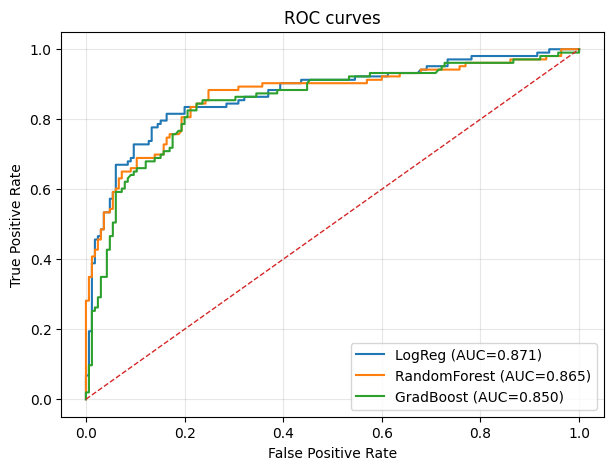

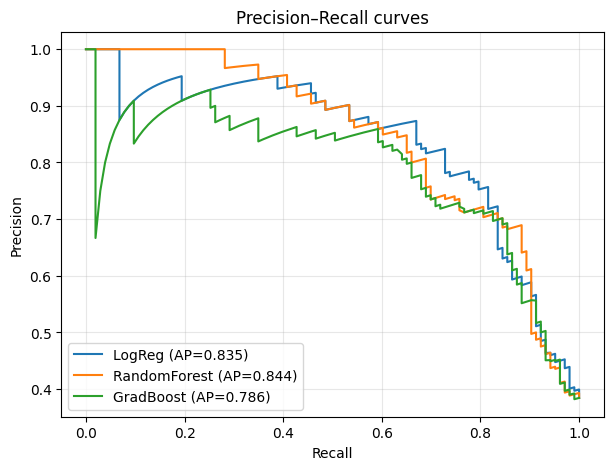

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve, average_precision_score,
    confusion_matrix, classification_report
)

X_tr, X_va, y_tr, y_va = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

models = {
    "LogReg": LogisticRegression(max_iter=2000, solver='lbfgs', C=0.3),
    "RandomForest": RandomForestClassifier(
        n_estimators=600, max_depth=6, min_samples_leaf=1,
        max_features='sqrt', n_jobs=-1, random_state=42
    ),
    "GradBoost": GradientBoostingClassifier(
        n_estimators=400, learning_rate=0.1, max_depth=2,
        min_samples_leaf=2, random_state=42
    )
}

try:
    NUMS
except NameError:
    NUMS = X.select_dtypes(include=[np.number]).columns.tolist()

scaler = StandardScaler()
X_tr_scaled = X_tr.copy()
X_va_scaled = X_va.copy()
if len(NUMS) > 0:
    X_tr_scaled[NUMS] = scaler.fit_transform(X_tr_scaled[NUMS])
    X_va_scaled[NUMS] = scaler.transform(X_va_scaled[NUMS])

results = []
roc_curves = {}
pr_curves  = {}

for name, model in models.items():
    if name == "LogReg":
        model.fit(X_tr_scaled, y_tr)
        proba = model.predict_proba(X_va_scaled)[:, 1]
        pred  = (proba >= 0.5).astype(int)
    else:
        model.fit(X_tr, y_tr)
        proba = model.predict_proba(X_va)[:, 1]
        pred  = model.predict(X_va)

    acc  = accuracy_score(y_va, pred)
    prec = precision_score(y_va, pred, zero_division=0)
    rec  = recall_score(y_va, pred, zero_division=0)
    f1   = f1_score(y_va, pred, zero_division=0)
    auc  = roc_auc_score(y_va, proba)
    ap   = average_precision_score(y_va, proba)

    cm = confusion_matrix(y_va, pred)
    results.append([name, acc, prec, rec, f1, auc, ap])
    print(f"\n=== {name} ===")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1:        {f1:.4f}")
    print(f"ROC-AUC:   {auc:.4f}")
    print(f"PR-AUC(AP):{ap:.4f}")
    print("Confusion matrix:\n", pd.DataFrame(cm, index=['True0','True1'], columns=['Pred0','Pred1']))

    fpr, tpr, _ = roc_curve(y_va, proba)
    roc_curves[name] = (fpr, tpr, auc)

    precisions, recalls, _ = precision_recall_curve(y_va, proba)
    pr_curves[name] = (precisions, recalls, ap)

res_df = pd.DataFrame(results, columns=['Model','Accuracy','Precision','Recall','F1','ROC_AUC','PR_AUC(AP)'])
print("\n\nSummary metrics:\n", res_df.sort_values('Accuracy', ascending=False))

plt.figure(figsize=(7,5))
for name, (fpr, tpr, auc) in roc_curves.items():
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
plt.plot([0,1],[0,1],'--', linewidth=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves")
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(7,5))
for name, (precisions, recalls, ap) in pr_curves.items():
    plt.plot(recalls, precisions, label=f"{name} (AP={ap:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall curves")
plt.legend(loc='lower left')
plt.grid(True, alpha=0.3)
plt.show()
